## 1: FrozenLakeの基本

In [ ]:
pip install gym

In [ ]:
import gym

env = gym.make('FrozenLake-v0')
env.render()


SFFF
FHFH
FFFH
HFFG


In [ ]:
env.desc

array([[b'S', b'F', b'F', b'F'],
       [b'F', b'H', b'F', b'H'],
       [b'F', b'F', b'F', b'H'],
       [b'H', b'F', b'F', b'G']], dtype='|S1')

In [ ]:
env.desc[1][2]

b'F'

In [ ]:
env.ncol

4

In [ ]:
env.nrow

4

In [ ]:
env.nS

16

状態s: どのマスにいるか

In [ ]:
env.nA

4

行動a: どの方向に「進みたい」と思うか (0:left, 1:down, 2:right, 3:up)

In [ ]:
env.reset()
env.step(3)
env.render()

  (Up)
SFFF
FHFH
FFFH
HFFG


In [ ]:
env.reset()

0

In [ ]:
env.render()


SFFF
FHFH
FFFH
HFFG


In [ ]:
env.step(0)
env.render()

  (Left)
SFFF
FHFH
FFFH
HFFG


In [ ]:
env.step(1)
env.render()

  (Down)
SFFF
FHFH
FFFH
HFFG


In [ ]:
env.step(2)
env.render()

  (Right)
SFFF
FHFH
FFFH
HFFG


In [ ]:
env.P[1]

{0: [(0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 5, 0.0, True)],
 1: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 5, 0.0, True),
  (0.3333333333333333, 2, 0.0, False)],
 2: [(0.3333333333333333, 5, 0.0, True),
  (0.3333333333333333, 2, 0.0, False),
  (0.3333333333333333, 1, 0.0, False)],
 3: [(0.3333333333333333, 2, 0.0, False),
  (0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)]}

P=(s: {a: prob, next_s})

In [ ]:
pl = Planner(env)
pl.plan()

,0,1,2,3
0,0.041687,0.023032,0.013350,0.009227
1,0.058035,-1.000000,-0.253537,-1.000000
2,0.094906,0.164183,0.141717,-1.000000
3,-1.000000,0.311031,0.561832,1.000000


## 2: 動的計画法

 *   状態sに対して、価値V(s)を計算する。
 *   価値が最大になる行動を行う。

更新の式
$$ V(s) = R(s) + \gamma \max_a \sum_{s^{\prime}} T(s^{\prime}|s, a) V(s^{\prime})$$

・価値反復法　

最初、V(s)を適当に定め、式を繰り返す。

$$ V_{1} = R(s)$$
$$ V(s)_{2} = R(s) + \gamma \max_a \sum_{s^{\prime}} T(s^{\prime}|s, a) R(s)$$
$$ V(s)_{3} = R(s) + \gamma \max_a \sum_{s^{\prime}} T(s^{\prime}|s, a) V(s)_{2}$$






In [ ]:
import pandas as pd

class Planner:
  def __init__(self, env):
    self.env=env
  
  def s_to_loc(self, s):
    row = s // self.env.ncol
    col = s % self.env.ncol
    return row, col
  
  def reward(self, s):
    row, col = self.s_to_loc(s)
    if self.env.desc[row][col] == b'H':
      return -1
    elif self.env.desc[row][col] == b'G':
      return 1
    else:
      return 0
  
  def plan(self, gamma=0.9, threshold=0.001):
    self.env.reset()
    V={}
    # 初期値設定
    for s in range(self.env.nS):
      V[s]=self.reward(s)

    while True:
      delta = 0
      # 全マスについてループさせる
      for s in V:
        row, col = self.s_to_loc(s)
        if self.env.desc[row][col] in [b'H', b'G']:
          continue
        expected_rewards = []
        for a in range(self.env.nA):
          r = 0
          for prob, next_s, _, _ in self.env.P[s][a]:
            # 場所:s, アクション:aの時の獲得できるスコアの期待値
            r += gamma * prob * V[next_s]
          expected_rewards.append(r)
        # 場所: sにおいての最大の期待値を格納する。
        max_rewards = max(expected_rewards)
        new_V = self.reward(s) + max_rewards
        # 各マスの価値の更新度合いの最大値
        delta = max(delta, abs(new_V - V[s]))
        V[s] = new_V
      if delta < threshold:
        break
    return self.dict_to_grid(V)

  def dict_to_grid(self, V):
    grid = []
    for i in range(self.env.nrow):
      row = [0] * self.env.ncol
      grid.append(row)
    for s in V:
      row, col = self.s_to_loc(s)
      grid[row][col] = V[s]
    return pd.DataFrame(grid)

#3: モンテカルロ法



*   「ゲームをやってみた結果、もらった報酬」をもとに価値計算
*   今回の価値は、Q(s, a)で表される、「行動の価値」
*   Q(s, a)は、「状態sでaを行った時にゲーム終了までに得られる報酬」
$$ G_{t} = r_{t+1} + r_{t+2} + ... + r_{T}$$
ただ、未来でもらえる報酬は不確かなので、「割引率」γをかける
$$ G_{t} = r_{t+1} + \gamma r_{t+2} + \gamma ^2 r_{t+3} + ... + \gamma ^{T-t-1} r_{T} $$
これを「割引現在価値」という。
更新の式
$$Q(s, a)⇦Q(s, a)+\alpha (G_t-Q(s, a))$$
αは、「学習率」で0から1をとる。Qの更新は1ゲーム終了したら行われる。



*   確率10%: 探索, 確率90%: 活用

探索: ランダムに行動する

活量: Q(s, a)から最善の行動をする。


## 3.1動的計画法との違い
$$ V(s) = R(s) + \gamma \max_a \sum_{s^{\prime}} T(s^{\prime}|s, a) V(s^{\prime})$$

$$Q(s, a)←Q(s, a)+\alpha (G_t-Q(s, a))$$

動的計画法の更新式には遷移確率が必要。但し、モンテカルロ法は経験則から計算を行うため、確率が必要ではない。

すなわち、汎用性がある。（現実世界、遷移確率がわからないものも多いため）

In [ ]:
import gym

env = gym.make('FrozenLake-v0', is_slippery=False)
env.render()


SFFF
FHFH
FFFH
HFFG


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Agent:
  def __init__(self, env):
    self.env = env
    self.Q = {}
    self.initialize()
    self.reward_log = []
  
  def initialize(self):
    for s in range(self.env.nS):
      self.Q[s] = [0] * self.env.nA
    self.env.reset()
  
  def policy(self, s, epsilon=0.1):
    if np.random.random() < epsilon:
      return np.random.randint(self.env.nA)
    else:
      if sum(self.Q[s]) == 0:
        return np.random.randint(self.env.nA)
      else:
        return np.argmax(self.Q[s])
  
  def MonteCalro(self, episode_count=1000, gamma=0.9, alpha=0.8):
    # epizode_count回のGを行う。
    for e in range(episode_count):
      self.env.reset()
      done = None
      experience_log = list()
      s = 0
      # 1Gが終わるまで(FrozenLakeの場合、goalに着く　or Hallに落ちるまで)
      while not done:
        a = self.policy(s)
        next_s, reward, done, _ = self.env.step(a)
        # 場所:s, 行動:a, 報酬:rewardを記録する。
        experience_log.append({'state':s, 'action':a, 'reward':reward})
        # aに従って、次の行動に移す。
        s = next_s
      else:
        # G終了時に獲得したrewardを記録
        self.reward_log.append(reward)
      for t, experience in enumerate(experience_log):
        G = 0
        i = 0
        for j in range(t, len(experience_log)):
          G += (gamma**i) * experience_log[j]['reward']
          i += 1
        s = experience['state']
        a = experience['action']
        # 更新の式
        self.Q[s][a] += alpha * (G - self.Q[s][a])
    return self.Q
  
  def q_learning(self, episode_count=1000, gamma=0.9, alpha=0.8):
    # epizode_count回のGを行う。
    for e in range(episode_count):
      self.env.reset()
      done = None
      s = 0
      # 1Gが終わるまで(FrozenLakeの場合、goalに着く　or Hallに落ちるまで)
      while not done:
        a = self.policy(s)
        next_s, reward, done, _ = self.env.step(a)
        # aに従って、次の行動に移す。

        G = reward + gamma * max(self.Q[next_s])
        self.Q[s][a] += alpha * (G - self.Q[s][a])

        s = next_s
      else:
        # G終了時に獲得したrewardを記録
        self.reward_log.append(reward)

  def SARSA(self, episode_count=1000, gamma=0.9, alpha=0.8):
    # epizode_count回のGを行う。
    for e in range(episode_count):
      self.env.reset()
      done = None
      s = 0
      a = self.policy(s)
      # 1Gが終わるまで(FrozenLakeの場合、goalに着く　or Hallに落ちるまで)
      while not done:
        next_s, reward, done, _ = self.env.step(a)
        next_a = self.policy(next_s)

        # aに従って、次の行動に移す。

        G = reward + gamma * self.Q[next_s][next_a]
        self.Q[s][a] += alpha * (G - self.Q[s][a])

        s = next_s
        a = next_a
      else:
        # G終了時に獲得したrewardを記録
        self.reward_log.append(reward)

  def show_reward(self, interval=50):
    average_rewards = {}
    for e in range(0, len(self.reward_log), interval):
      average_rewards[e] = np.mean(self.reward_log[e:e+interval])
    return pd.Series(average_rewards).plot()

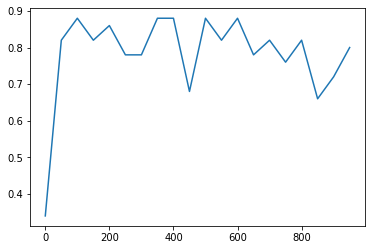

In [28]:
agent = Agent(env)
agent.MonteCalro()
agent.show_reward()

# 4: Q-learning

更新の式:
$$Q(s, a)←Q(s, a)+\alpha (G_t-Q(s, a))$$
モンテカルロ法:
$$ G_{t} = r_{t+1} + \gamma r_{t+2} + \gamma ^2 r_{t+3} + ... + \gamma ^{T-t-1} r_{T} $$
Q-learning:
$$ G_t = \gamma_{t+1} +\gamma max[Q(s_{t+1}, a)] $$
SARSA(State-Aciton-Reward-State-Action):
$$ G_t = \gamma_{t+1} +\gamma Q(s_{t+1}, a_{t+1}) $$
但し、
$$ a_{t+1} = \pi(s_{t+1}) $$
πはpolicy

In [14]:
import gym
env = gym.make('FrozenLake-v0', is_slippery=False)
env.render()


SFFF
FHFH
FFFH
HFFG


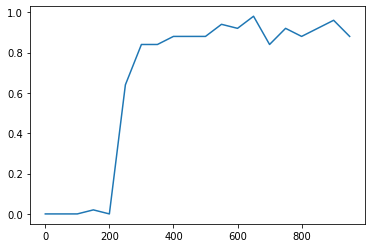

In [15]:
agent = Agent(env)
agent.q_learning()
agent.show_reward()

# 5: SARSA

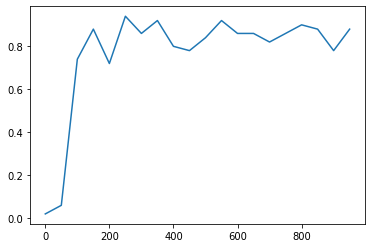

In [33]:
agent = Agent(env)
agent.SARSA()
agent.show_reward()

## 5.1 Q-learningとSARSAの違い
Q-learningの方が楽観的、SARSAの方が現実的
→Q-learningは必ず次も最大の行動を取れる前提、SARSAは数%の確率でランダムに行動するように更新式を定義しているため



# 6: Actor-Critic法

In [49]:
class Actor:
  def __init__(self, env):
    self.env = env
    self.Q = {}
    self.initialize()

  def initialize(self):
    for s in range(self.env.nS):
      self.Q[s] = [0] * self.env.nA
    self.env.reset()
  
  def policy(self, s, epsilon=0.1):
    if np.random.random() < epsilon:
      return np.random.randint(self.env.nA)
    else:
      if sum(self.Q[s]) == 0:
        return np.random.randint(self.env.nA)
      else:
        return np.argmax(self.Q[s])

class Critic:
  def __init__(self, env):
    # 状態ごとに決まる価値
    self.V = np.zeros(env.nS)

class ActorCritic:
  def __init__(self, eng, actor_class, critic_class):
    self.env = env
    self.actor_class = actor_class
    self.critic_class = critic_class
    self.reward_log = []
  
  def learn(self, episode_count=1000, gamma=0.9, alpha=0.8):
    actor = self.actor_class(self.env)
    critic = self.critic_class(self.env)

    for e in range(episode_count):
      self.env.reset()
      done = None
      s = 0
      # 1Gが終わるまで(FrozenLakeの場合、goalに着く　or Hallに落ちるまで)
      while not done:
        a = actor.policy(s)
        next_s, reward, done, _ = self.env.step(a)
        # aに従って、次の行動に移す。

        G = reward + gamma * critic.V[next_s]
        actor.Q[s][a] += alpha * (G - critic.V[s])
        critic.V[s] += alpha * (G - critic.V[s])
        s = next_s
      else:
        # G終了時に獲得したrewardを記録
        self.reward_log.append(reward)

  def show_reward(self, interval=50):
    average_rewards = {}
    for e in range(0, len(self.reward_log), interval):
      average_rewards[e] = np.mean(self.reward_log[e:e+interval])
    return pd.Series(average_rewards).plot()

In [50]:
ac = ActorCritic(env, Actor, Critic)
ac.learn()

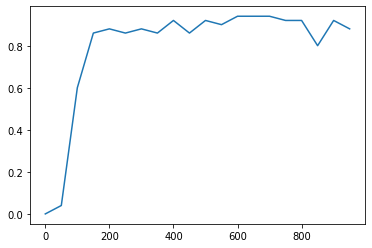

In [51]:
ac.show_reward()